In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

## The gamma distribution

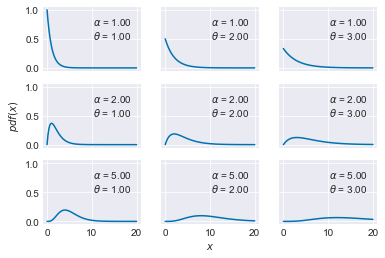

In [2]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x))
        ax[i,j].plot(0, 0, 
        label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i,j].legend()
ax[2,1].set_xlabel('$x$')
ax[1,0].set_ylabel('$pdf(x)$')
plt.savefig('B04958_04_00.png', dpi=300, figsize=(5.5, 5.5));

## Simple linear regression

In [3]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

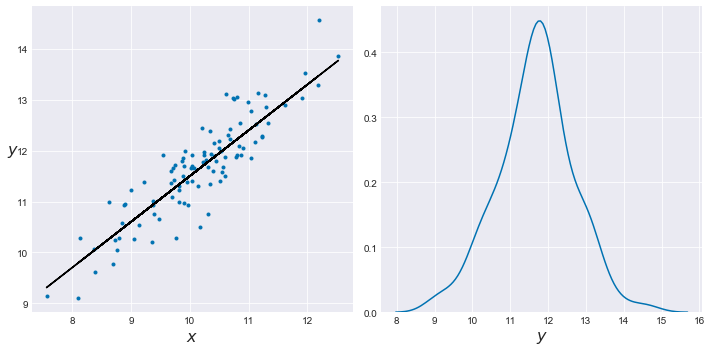

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'C0.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_02.png', dpi=300, figsize=(5.5, 5.5))

In [5]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    # ## In this example we are deliberativelly choosing the metropolis sampler
    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(10000, step=step, start=start)   

logp = -66.676, ||grad|| = 48.412: 100%|██████████| 38/38 [00:00<00:00, 384.72it/s]s]12it/s]
100%|██████████| 10500/10500 [00:12<00:00, 818.60it/s]


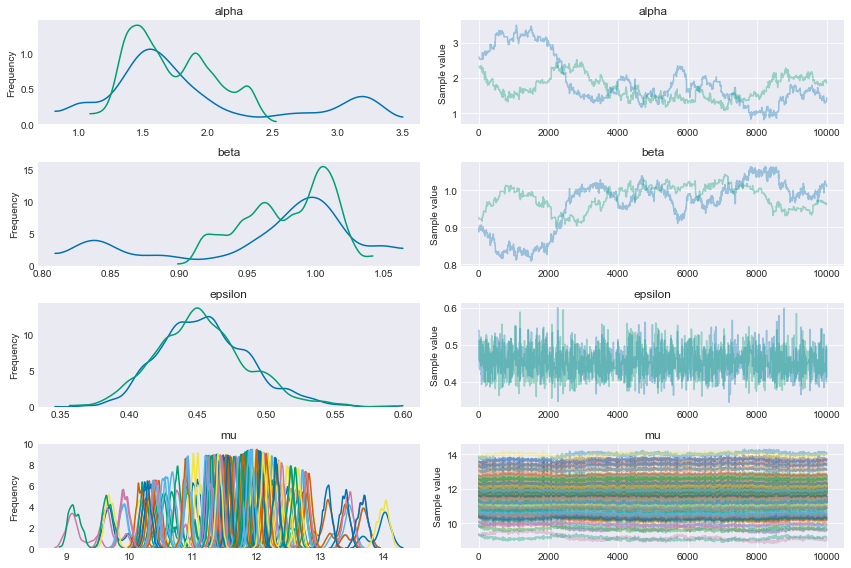

In [6]:
pm.traceplot(trace)
plt.savefig('B04958_04_03.png', dpi=300, figsize=(5.5, 5.5))

In [7]:
#pm.summary(trace)

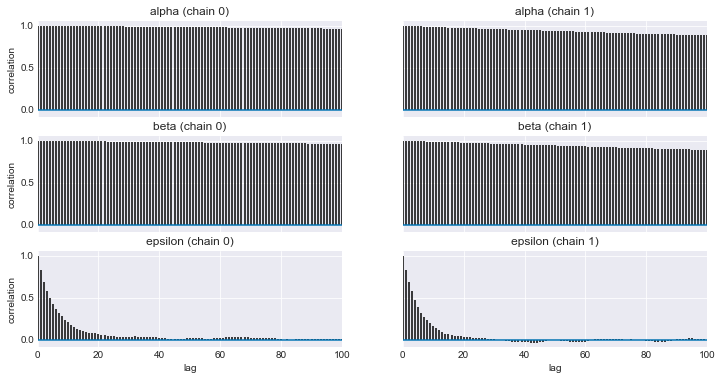

In [8]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)
plt.savefig('B04958_04_04.png', dpi=300, figsize=(5.5, 5.5));

### Modyfing the data before running the models

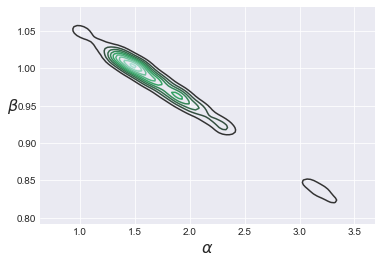

In [9]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)
plt.savefig('B04958_04_05.png', dpi=300, figsize=(5.5, 5.5));

### Changing the sampling method

In [10]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_n = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:22<00:00, 100.14it/s]
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.8916561815, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


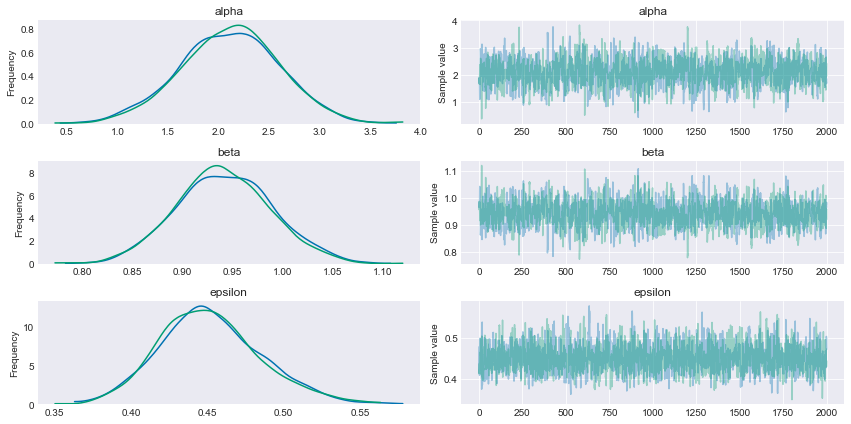

In [11]:
pm.traceplot(trace_n, varnames);

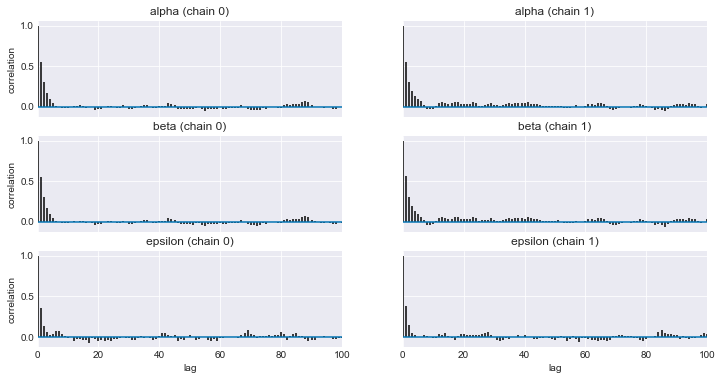

In [12]:
pm.autocorrplot(trace_n, varnames);

In [13]:
pm.summary(trace_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.11,0.49,1.49e-02,1.17,3.09,1133.0,1.0
beta,0.94,0.05,1.46e-03,0.85,1.04,1136.0,1.0
epsilon,0.45,0.03,7.51e-04,0.39,0.52,1649.0,1.0


### Posterior predictive checks

In [14]:
ppc = pm.sample_ppc(trace_n, samples=231, model=model_n)

  0%|          | 0/231 [00:00<?, ?it/s]


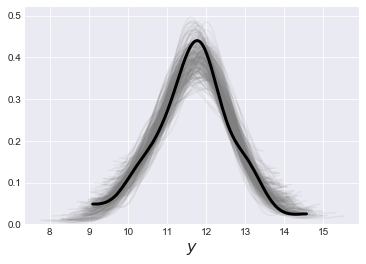

In [15]:
# predicted data
_, ax = plt.subplots()
for y_tilde in ppc['y_pred']:
    pm.kdeplot(y_tilde, alpha=0.1, c='gray', ax=ax)
# actual data
pm.kdeplot(y, linewidth=3, color='k', ax=ax)
    
plt.xlabel('$y$', fontsize=16);

### interpreting the posterior

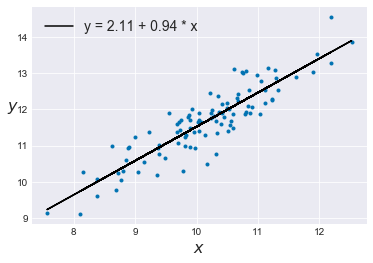

In [16]:
plt.plot(x, y, 'C0.');
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()
plt.plot(x, alpha_m + beta_m * x,
         c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_06.png', dpi=300, figsize=(5.5, 5.5));

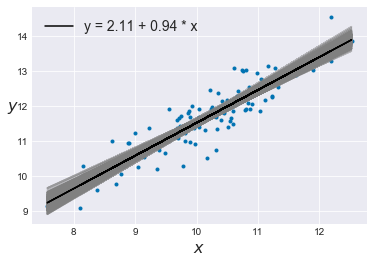

In [17]:
plt.plot(x, y, 'C0.');

idx = range(0, len(trace_n['alpha']), 10)
plt.plot(x, trace_n['alpha'][idx] + trace_n['beta'][idx] *  x[:,np.newaxis], c='gray', alpha=0.5);

plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_07.png', dpi=300, figsize=(5.5, 5.5));

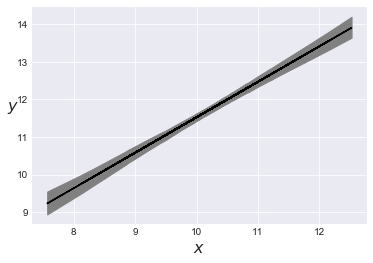

In [18]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_n['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_08.png', dpi=300, figsize=(5.5, 5.5));

In [19]:
ppc = pm.sample_ppc(trace_n, samples=1000, model=model_n)

  0%|          | 0/1000 [00:00<?, ?it/s]


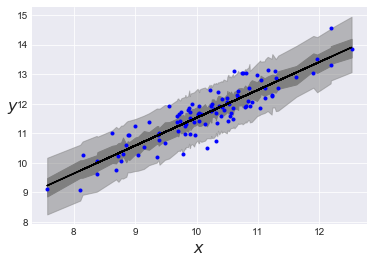

In [20]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_09.png', dpi=300, figsize=(5.5, 5.5));

## Pearson correlation coefficient

In [21]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) ** 2)

    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)
    
    trace_n = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:22<00:00, 113.49it/s]


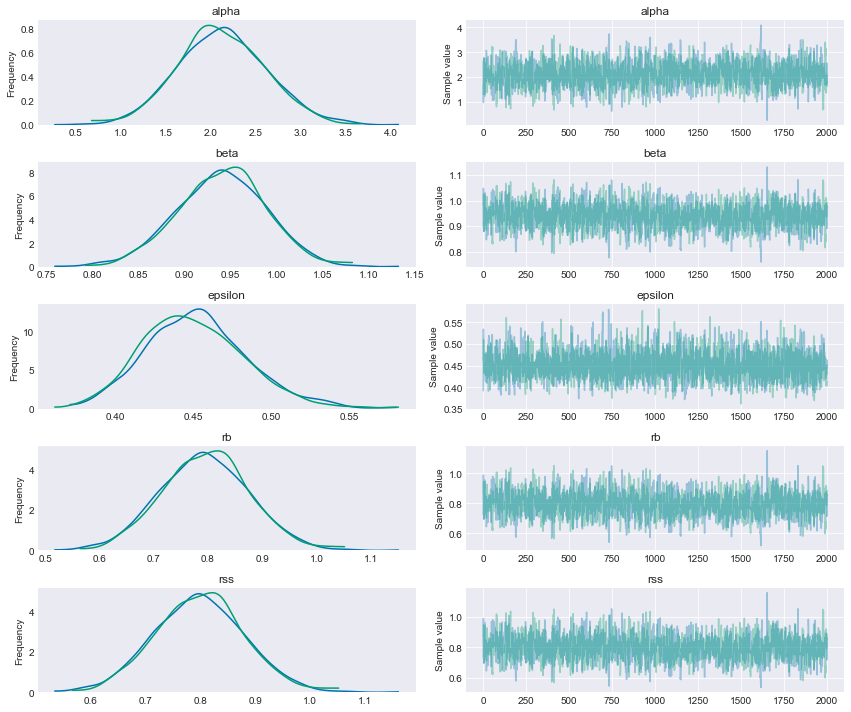

In [22]:
pm.traceplot(trace_n)
plt.savefig('B04958_04_10.png', dpi=300, figsize=(5.5, 5.5));

In [23]:
pm.summary(trace_n)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.13,0.49,1.33e-02,1.20,3.10,1265.0,1.0
beta,0.94,0.05,1.30e-03,0.84,1.03,1284.0,1.0
epsilon,0.45,0.03,7.35e-04,0.39,0.52,1847.0,1.0
rb,0.80,0.08,2.19e-03,0.64,0.95,1292.0,1.0
rss,0.80,0.08,2.20e-03,0.64,0.95,1287.0,1.0


### The multivariate normal distribution 
Actually the bivariate

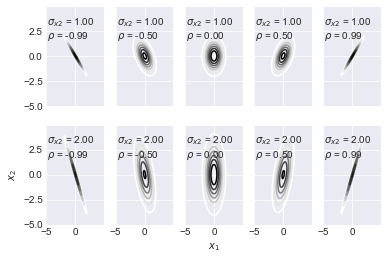

In [24]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k; pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)
#f.figure(figsize=(5, 1))
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho], [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i,j].contour(k, l, rv.pdf(pos))
        ax[i,j].plot(0, 0, 
        label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax[i,j].legend()
ax[1,2].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')
plt.savefig('B04958_04_11.png', dpi=300, figsize=(5.5, 5.5));

In [25]:
data = np.stack((x, y)).T

In [26]:
with pm.Model() as pearson_model:
    
    mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)
    
    sigma_1 = pm.HalfNormal('simga_1', 10)
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    rho = pm.Uniform('rho', -1, 1)
    
    cov = pm.math.stack(([sigma_1**2, sigma_1*sigma_2*rho], [sigma_1*sigma_2*rho, sigma_2**2]))
    
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)

    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:29<00:00, 51.51it/s]

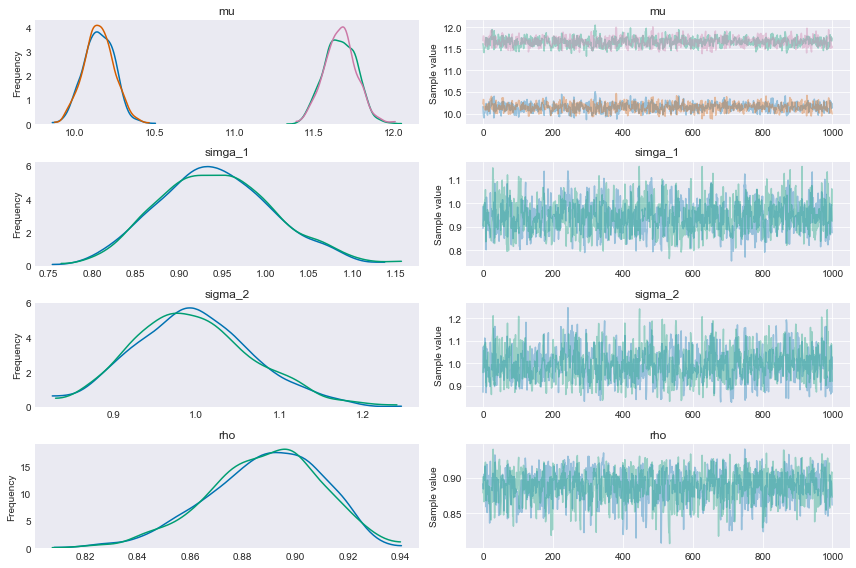

In [27]:
pm.traceplot(trace_p);
plt.savefig('B04958_04_12.png', dpi=300, figsize=(5.5, 5.5));

In [28]:
pm.summary(trace_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,10.15,0.10,3.00e-03,9.96,10.33,941.0,1.0
mu__1,11.67,0.10,3.28e-03,11.46,11.84,890.0,1.0
simga_1,0.94,0.07,2.22e-03,0.81,1.07,853.0,1.0
sigma_2,1.00,0.07,2.47e-03,0.87,1.14,780.0,1.0
rho,0.89,0.02,7.43e-04,0.85,0.93,864.0,1.0


## Robust linear regression

In [29]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

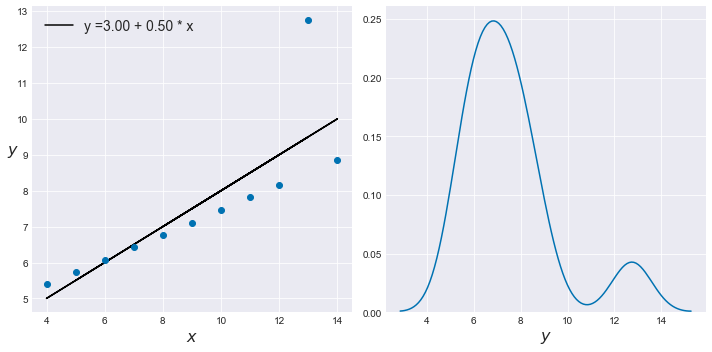

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k',
         label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_13.png', dpi=300, figsize=(5.5, 5.5));

In [31]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3,
                         sd=epsilon, nu=nu, observed=y_3)
    
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:23<00:00, 107.87it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f148d6a9358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f148d9dc278>]], dtype=object)

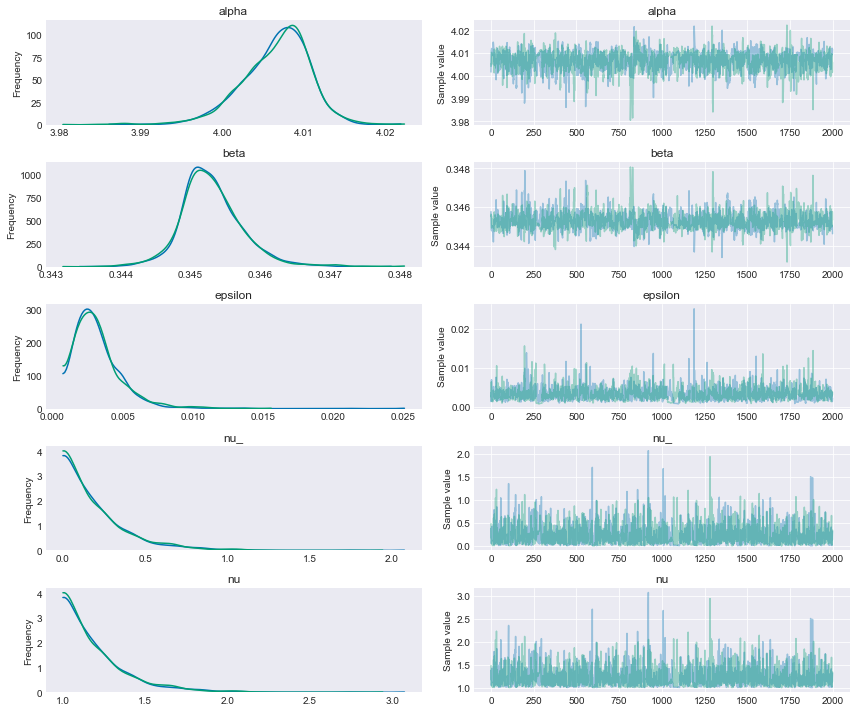

In [32]:
pm.traceplot(trace_t)

In [33]:
pm.summary(trace_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,4.01e+00,4.28e-03,1.33e-04,4.00e+00,4.01e+00,896.0,1.0
beta,3.45e-01,4.53e-04,1.43e-05,3.44e-01,3.46e-01,907.0,1.0
epsilon,3.26e-03,1.74e-03,5.54e-05,7.47e-04,6.32e-03,836.0,1.0
nu_,2.08e-01,2.10e-01,4.54e-03,1.98e-05,6.35e-01,2025.0,1.0
nu,1.21e+00,2.10e-01,4.54e-03,1.00e+00,1.64e+00,2025.0,1.0


In [34]:
#pm.autocorrplot(cadena_t, varnames);

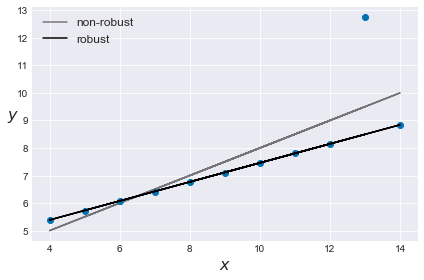

In [35]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

plt.savefig('B04958_04_14.png', dpi=300, figsize=(5.5, 5.5));

In [36]:
ppc = pm.sample_ppc(trace_t, samples=200, model=model_t, random_seed=2)

  0%|          | 0/200 [00:00<?, ?it/s]


/home/osvaldo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2401: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


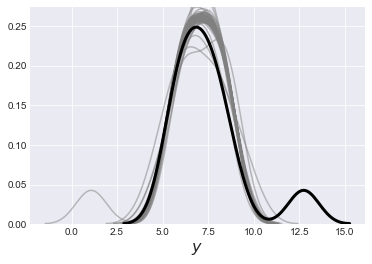

In [37]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='gray')

# actual data
sns.kdeplot(y_3, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16)
plt.savefig('B04958_04_15.png', dpi=300, figsize=(5.5, 5.5));

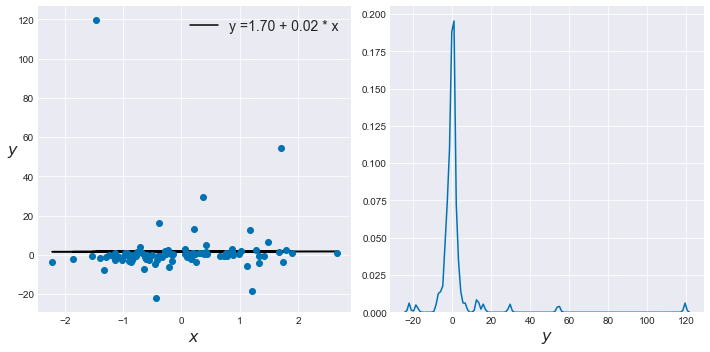

In [38]:
np.random.seed(314)
x_4 = np.random.normal(size=100)
y_4 = x_4 + np.random.standard_t(df=1, size=100) # experiments with different values of df

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]
plt.plot(x_4, (alpha_c + beta_c* x_4), 'k', 
         label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_4, y_4, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_4);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

## Hierarchical linear regression

In [39]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

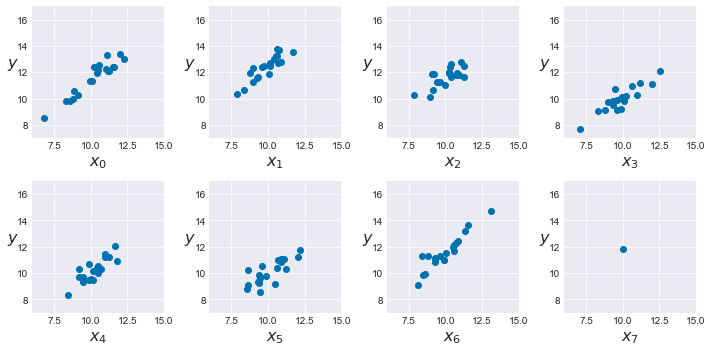

In [40]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_16.png', dpi=300, figsize=(5.5, 5.5));

In [41]:
x_centered = x_m - x_m.mean()

In [42]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu= alpha_tmp[idx] + beta[idx] * x_centered,
                         sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 

    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:11<00:00, 223.20it/s]


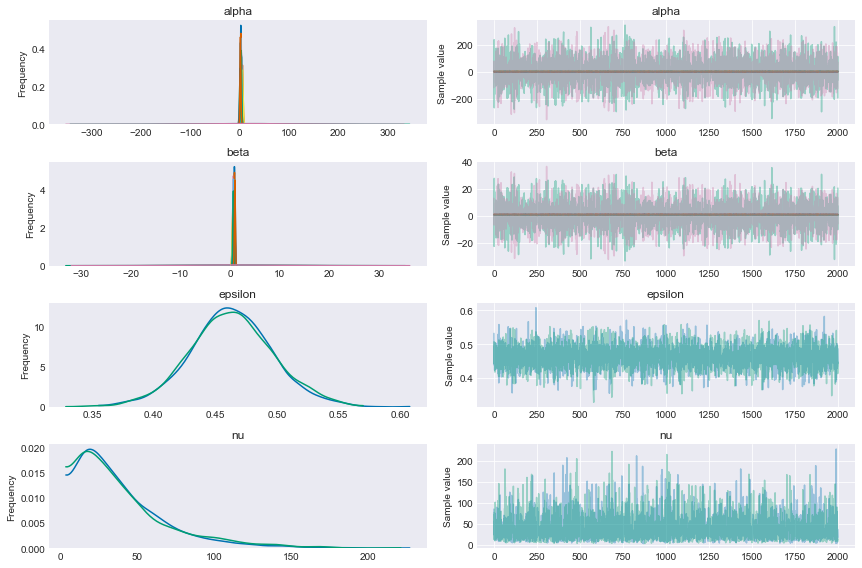

In [43]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)
plt.savefig('B04958_04_17.png', dpi=300, figsize=(5.5, 5.5));

In [44]:
#pm.autocorrplot(trace_up, varnames=[epsilon, nu]);

In [45]:
pm.summary(trace_up, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,2.44,0.78,7.71e-03,0.99,4.06,4000.0,1.0
alpha__1,3.71,1.13,1.47e-02,1.63,6.12,4000.0,1.0
alpha__2,5.67,1.31,1.44e-02,3.17,8.30,4000.0,1.0
alpha__3,3.05,0.87,8.91e-03,1.29,4.79,4000.0,1.0
alpha__4,1.32,1.34,1.15e-02,-1.21,4.03,4000.0,1.0
alpha__5,3.25,1.03,1.07e-02,1.22,5.22,4000.0,1.0
alpha__6,1.75,0.91,9.31e-03,-0.09,3.44,4000.0,1.0
alpha__7,8.37,101.98,1.03e+00,-197.80,206.25,4000.0,1.0
beta__0,0.89,0.08,7.73e-04,0.75,1.05,4000.0,1.0
beta__1,0.88,0.11,1.48e-03,0.65,1.10,4000.0,1.0


In [46]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)

    # a prioris
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    trace_hm = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 77%|███████▋  | 1152/1500 [00:12<00:02, 117.42it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 36 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 99%|█████████▉| 1482/1500 [00:15<00:00, 169.58it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 12 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [00:15<00:00, 98.36it/s] 


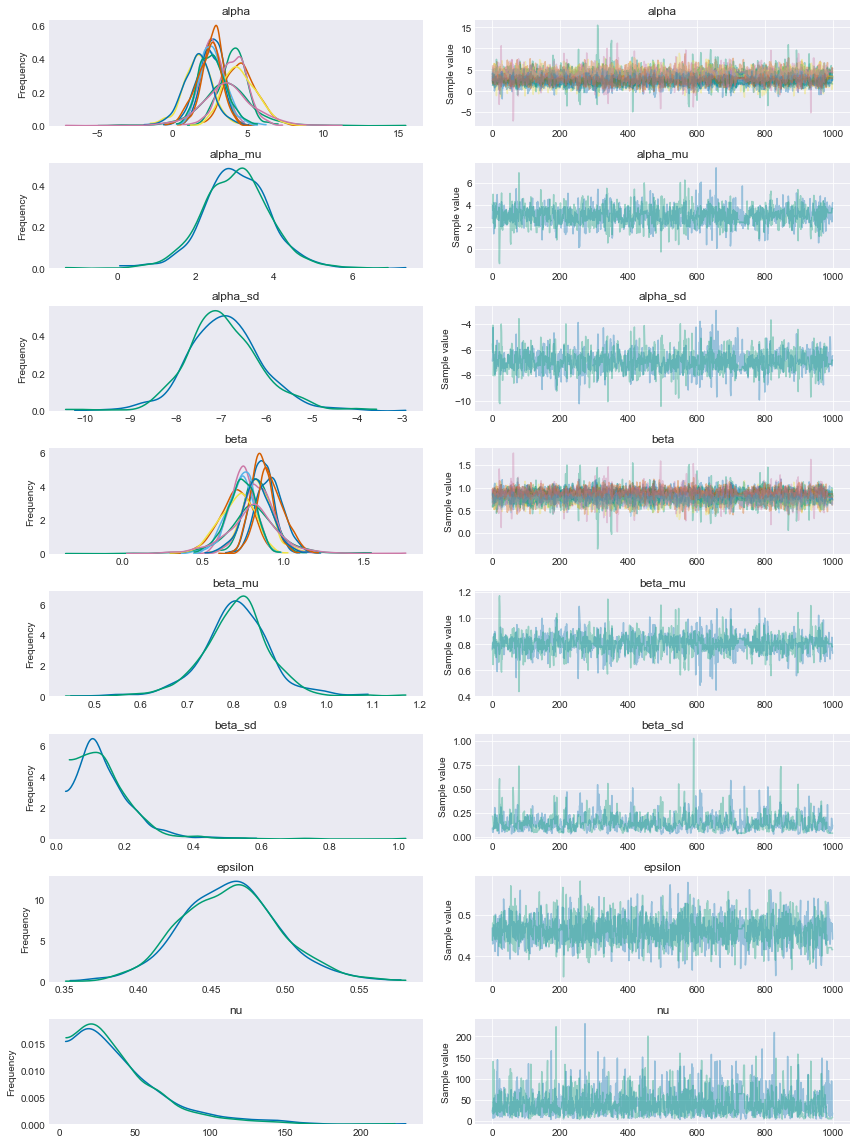

In [47]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta',
          'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(trace_hm, varnames)
plt.savefig('B04958_04_19.png', dpi=300, figsize=(5.5, 5.5));

In [48]:
pm.summary(trace_hm, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,2.71,0.69,1.37e-02,1.42,4.09,2000.0,1.0
alpha__1,4.04,0.91,1.83e-02,2.15,5.74,2000.0,1.0
alpha__2,4.55,1.08,3.29e-02,2.37,6.54,908.0,1.0
alpha__3,2.64,0.79,1.84e-02,1.07,4.14,1835.0,1.0
alpha__4,1.67,0.98,2.15e-02,-0.50,3.57,2000.0,1.0
alpha__5,2.68,0.91,2.48e-02,0.95,4.40,1108.0,1.0
alpha__6,2.39,0.85,2.11e-02,0.65,3.94,1481.0,1.0
alpha__7,3.60,1.91,4.97e-02,-0.04,7.51,1402.0,1.0
alpha_mu,3.03,0.86,2.36e-02,1.44,4.82,1309.0,1.0
alpha_sd,-6.93,0.85,2.08e-02,-8.59,-5.23,1433.0,1.0


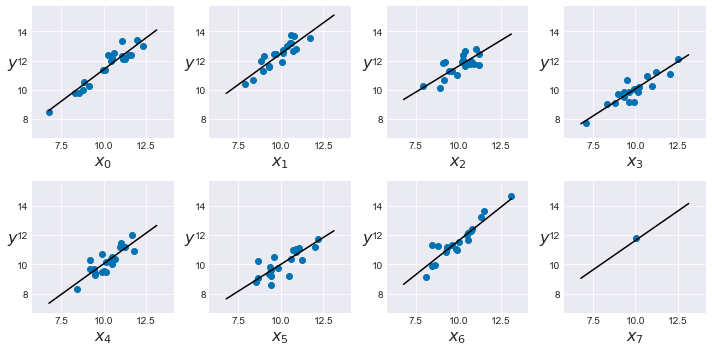

In [49]:
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2, 4, i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    alfa_m = trace_hm['alpha'][:,i].mean()
    beta_m = trace_hm['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m * x_range, c='k',
             label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_20.png', dpi=300, figsize=(5.5, 5.5));

## Polynomial regression

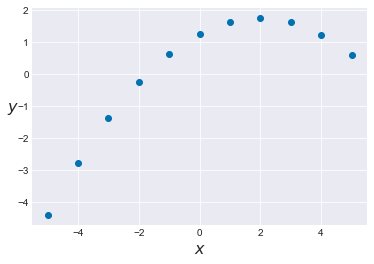

In [50]:
#ans = sns.load_dataset('anscombe')
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_21.png', dpi=300, figsize=(5.5, 5.5))

In [51]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)
    
    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 69%|██████▊   | 1718/2500 [00:10<00:02, 360.10it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.911186093697, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2500/2500 [00:12<00:00, 391.05it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.901601105786, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



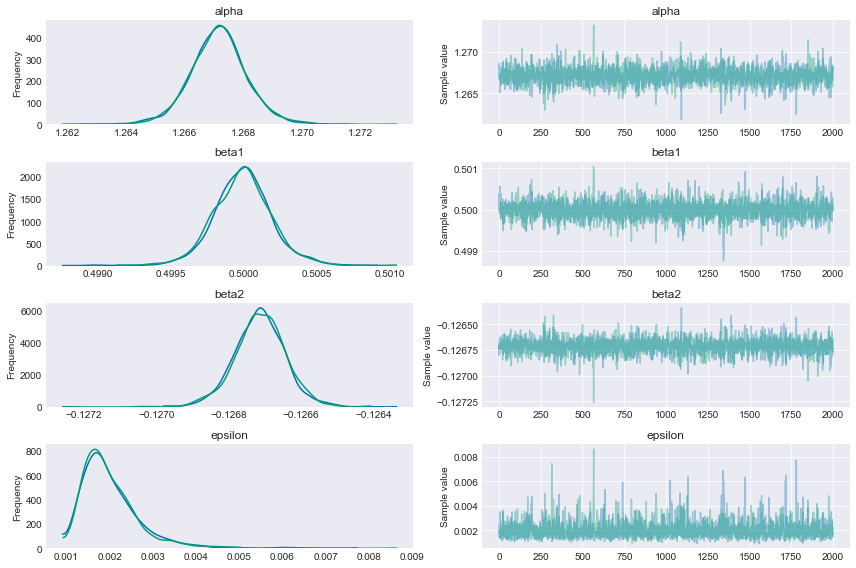

In [52]:
pm.traceplot(trace_poly)
plt.savefig('B04958_04_22.png', dpi=300, figsize=(5.5, 5.5))

In [53]:
pm.summary(trace_poly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.27e+00,9.73e-04,2.29e-05,1.27e+00,1.27e+00,1891.0,1.0
beta1,5.00e-01,2.04e-04,4.30e-06,5.00e-01,5.00e-01,2103.0,1.0
beta2,-1.27e-01,7.18e-05,1.66e-06,-1.27e-01,-1.27e-01,1932.0,1.0
epsilon,2.02e-03,6.83e-04,1.89e-05,1.07e-03,3.36e-03,1287.0,1.0


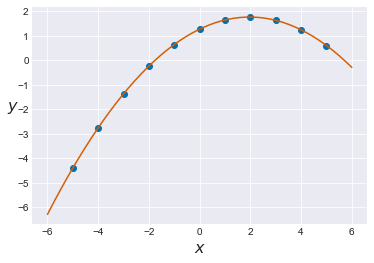

In [54]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_p, y_p, c='C2')
plt.savefig('B04958_04_23.png', dpi=300, figsize=(5.5, 5.5))

## Multiple Linear regression

In [55]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

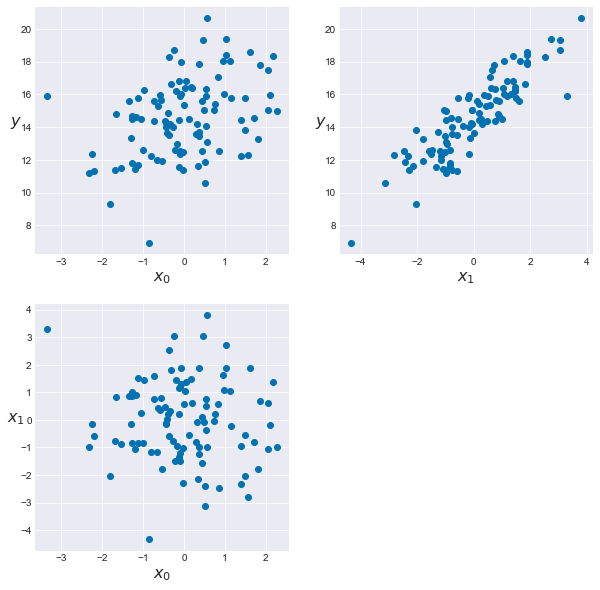

In [56]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)
plt.savefig('B04958_04_25.png', dpi=300, figsize=(5.5, 5.5))

In [57]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha_tmp + pm.math.dot(beta, X_centered)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean)) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_mlr = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 85%|████████▍ | 4659/5500 [00:14<00:02, 387.58it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.878761391783, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|█████████▉| 5476/5500 [00:16<00:00, 435.63it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.884318619382, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 5500/5500 [00:16<00:00, 330.84it/s]


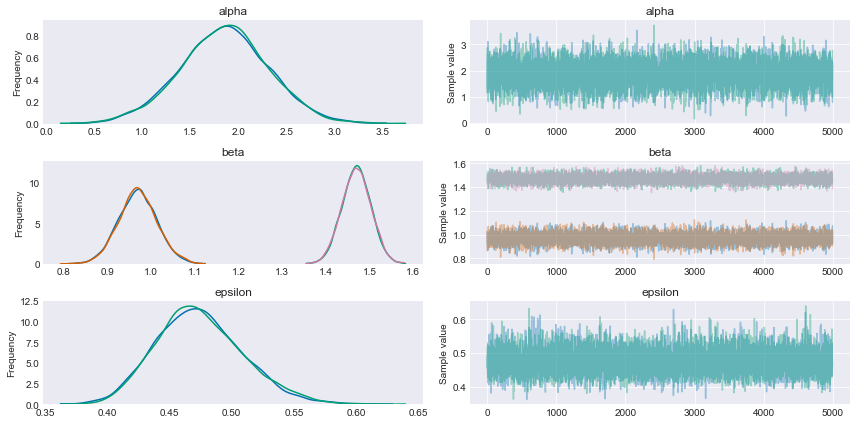

In [58]:
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(trace_mlr, varnames)
plt.savefig('B04958_04_26.png', dpi=300, figsize=(5.5, 5.5));

In [59]:
pm.summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,1.85,0.46,4.62e-03,0.95,2.76,10000.0,1.0
beta__0,0.97,0.04,4.34e-04,0.88,1.05,10000.0,1.0
beta__1,1.47,0.03,3.06e-04,1.41,1.53,10000.0,1.0
epsilon,0.47,0.03,3.89e-04,0.41,0.54,10000.0,1.0


In [60]:
pm.summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,1.85,0.46,4.62e-03,0.95,2.76,10000.0,1.0
beta__0,0.97,0.04,4.34e-04,0.88,1.05,10000.0,1.0
beta__1,1.47,0.03,3.06e-04,1.41,1.53,10000.0,1.0
epsilon,0.47,0.03,3.89e-04,0.41,0.54,10000.0,1.0


## Confounding variables and redundant variables

In [61]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

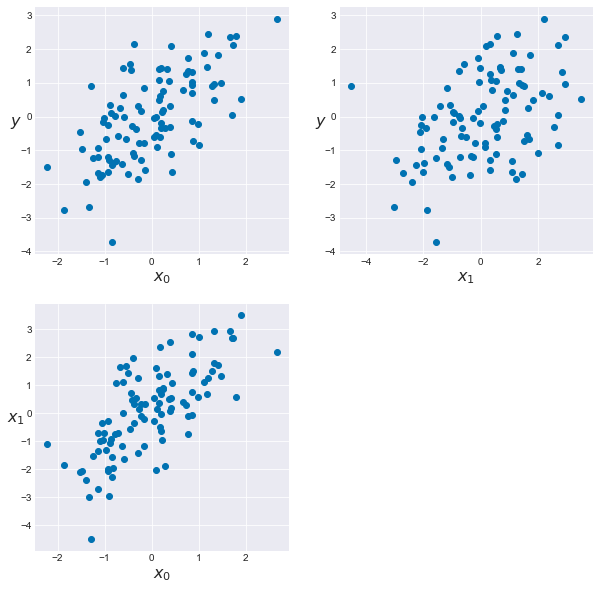

In [62]:
scatter_plot(X, y)
plt.savefig('B04958_04_27.png', dpi=300, figsize=(5.5, 5.5));

In [63]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
 
    trace_red = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:11<00:00, 475.64it/s]


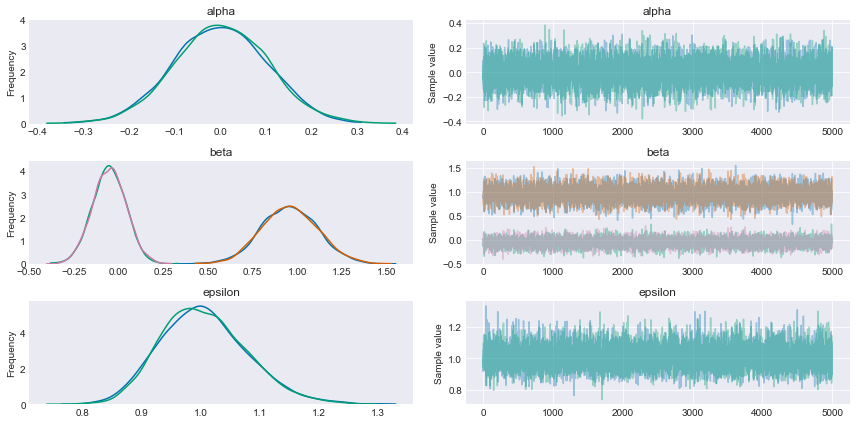

In [64]:
pm.traceplot(trace_red)
plt.savefig('B04958_04_28.png', dpi=300, figsize=(5.5, 5.5))

In [65]:
pm.summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.01e-03,0.10,1.00e-03,-0.20,0.19,8659.0,1.0
beta__0,9.56e-01,0.16,1.62e-03,0.66,1.27,7663.0,1.0
beta__1,-5.17e-02,0.09,1.02e-03,-0.25,0.12,7721.0,1.0
epsilon,1.01e+00,0.07,7.62e-04,0.87,1.15,8095.0,1.0


Text(0,0.5,'$\\beta_2$')

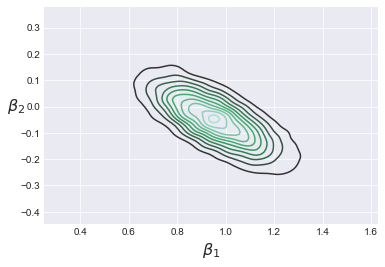

In [66]:
sns.kdeplot(trace_red['beta'][:,0], trace_red['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)
#plt.savefig('B04958_04_29.png', dpi=300, figsize=(5.5, 5.5));

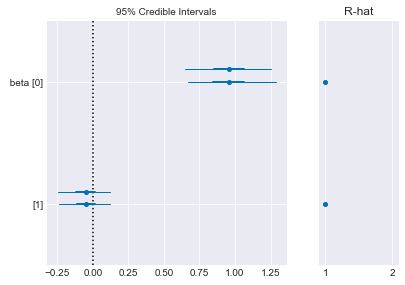

In [67]:
pm.forestplot(trace_red, varnames=['beta'])
#plt.savefig('B04958_04_30.png', dpi=300, figsize=(5.5, 5.5))

## Masking effect variables

In [68]:
np.random.seed(314)
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

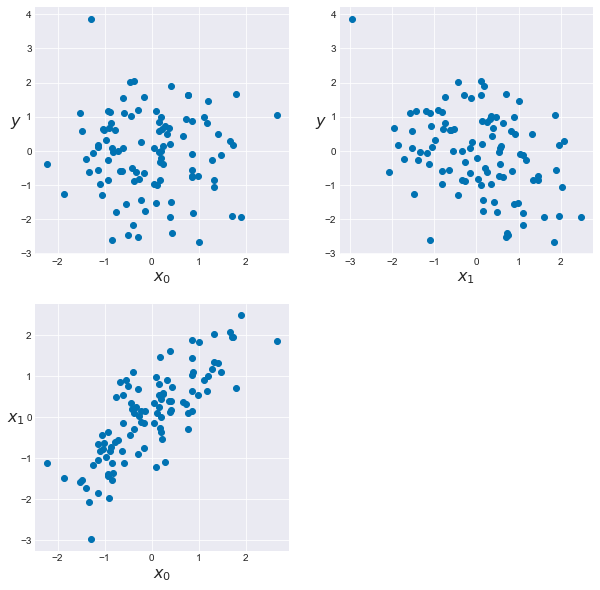

In [69]:
scatter_plot(X, y)
plt.savefig('B04958_04_31.png', dpi=300, figsize=(5.5, 5.5));

In [70]:
with pm.Model() as model_ma:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    #trace_ma = pm.sample(5000, step=step, start=start)
    
    trace_ma = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:11<00:00, 466.93it/s]


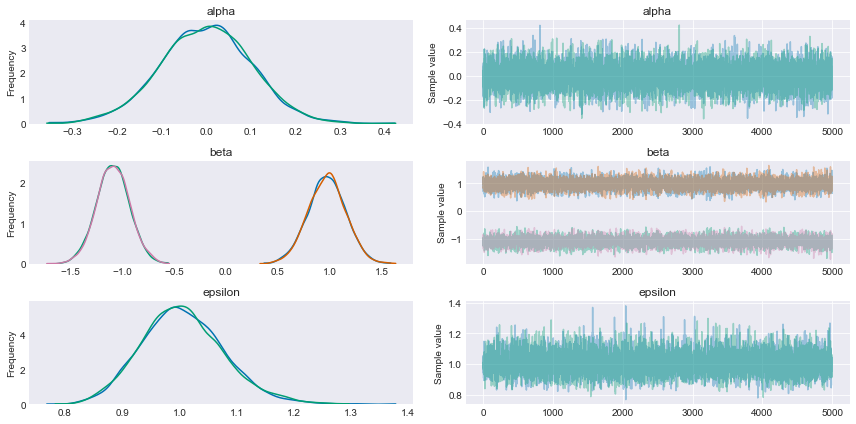

In [71]:
pm.traceplot(trace_ma)
plt.savefig('B04958_04_32.png', dpi=300, figsize=(5.5, 5.5));

In [72]:
pm.summary(trace_ma)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-2.17e-04,0.10,9.87e-04,-0.20,0.20,9336.0,1.0
beta__0,9.74e-01,0.18,2.20e-03,0.62,1.33,6796.0,1.0
beta__1,-1.09e+00,0.16,1.97e-03,-1.40,-0.77,5982.0,1.0
epsilon,1.01e+00,0.07,7.74e-04,0.87,1.15,8440.0,1.0


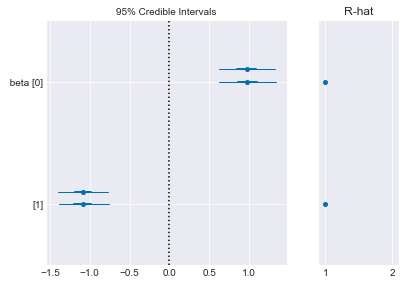

In [73]:
pm.forestplot(trace_ma, varnames=['beta']);
plt.savefig('B04958_04_33.png', dpi=300, figsize=(5.5, 5.5));

In [74]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo debian stretch/sid y usando:
Python 3.6.2
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.3
SciPy 1.0.0
Matplotlib 2.1.0
Seaborn 0.8.0

